# Import Packages

In [1]:
import os
from glob import glob
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import functional as F

# Dataset
## define dataset

In [2]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, train=True):
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.data_list = os.listdir(self.data_dir)
        self.channel = 1259
        self.data_indices = [
            (data_index, channel_index)
            for data_index in range(len(self.data_list))
            for channel_index in range(self.channel)
        ]
        self.invalid_indices = set()

    def __len__(self):
        return len(self.data_indices)
        
    def random_flip(self, sample, label):
        if np.random.rand() > 0.5:
            sample = np.flip(sample, axis=0)
            label = np.flip(label, axis=0)
        if np.random.rand() > 0.5:
            sample = np.flip(sample, axis=1)
            label = np.flip(label, axis=1)
        return sample, label

    def random_rotate(self, sample, label):
        k = np.random.choice([0, 1, 2, 3])
        sample = np.rot90(sample, k)
        label = np.rot90(label, k)
        return sample, label

    def add_noise(self, sample):
        noise = np.random.normal(0, 0.01, sample.shape)
        return sample + noise

    def __getitem__(self, index):
        while index < len(self.data_indices):
            try:
                data_index, channel_index = self.data_indices[index]
                data_path = os.path.join(self.data_dir, self.data_list[data_index])

                cube_path = glob(os.path.join(data_path, 'seismicCubes_RFC_fullstack*'))[0]
                mask_path = glob(os.path.join(data_path, 'fault_segments*'))[0]
                cube = np.load(cube_path)
                maskcube = np.load(mask_path)

                image = cube[:, :, channel_index]
                mask = maskcube[:, :, channel_index]

                if image.shape != (300, 300) or mask.shape != (300, 300):
                    raise ValueError(f"Unexpected shape for image/mask at index {index},{mask_path}")

                if self.transform:
                    image = self.transform(image).float()
                    mask = self.transform(mask).float()

                return image, mask

            except Exception as e:
                print(f"Error at index {index}: {e}")
                self.invalid_indices.add(index)
                index += 1

        raise RuntimeError("No valid data found in the dataset.")

    def get_invalid_indices(self):
        return self.invalid_indices

## initialize dataset

Image shape torch.Size([1, 320, 320])


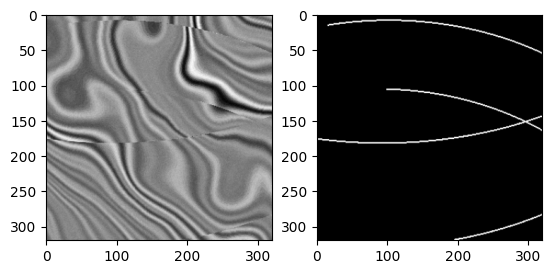

Training set: 1008 images
Validation set: 251 images
Test set: 1 cubes


In [3]:
train_dataset_dir = "/work/winlai0921/dataset/train/all_data"
test_dataset_dir = "/work/winlai0921/dataset/test/all_data"
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((320, 320))
                                      ])
full_train_dataset = ImageDataset(train_dataset_dir, train_transform, train=True)
train_dataset, val_dataset = random_split(full_train_dataset, [0.8, 0.2])

image, mask = train_dataset[200]
print('Image shape', image.shape)
plt.subplot(1, 2, 1)
plt.imshow(image[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask[0], cmap='gray')
plt.show()

print('Training set:', len(train_dataset), 'images')
print('Validation set:', len(val_dataset), 'images')

## initialize dataloader

In [4]:
batch_size = 8
class_num = 2
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

# Functions
## loss function

In [14]:
class DecoupledDiceLoss(nn.Module):
    def __init__(self, smooth=1e-8, alpha=1, num_classes=2):
        super(DecoupledDiceLoss, self).__init__()
        self.smooth = smooth
        self.alpha = alpha
        self.num_classes = num_classes

    def forward(self, preds, targets):
        targets = targets.squeeze(1)
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        preds_soft = F.softmax(preds, dim=1)

        intersection = preds_soft * targets_one_hot
        intersection_sum = intersection.sum(dim=(2, 3))
        preds_sum = preds_soft.sum(dim=(2, 3))
        targets_sum = targets_one_hot.sum(dim=(2, 3))
        union = preds_sum + targets_sum  # [4, 2]

        dice = (2 * intersection_sum + self.smooth) / (union + self.smooth)

        loss_TC = 1 - dice[:, 1]
        loss_NTC = 1 - dice[:, 0]

        loss = self.alpha * loss_TC + (1 - self.alpha) * loss_NTC
        return loss.mean()

## evaluation functions

In [6]:
def calculate_miou(preds, targets, num_classes):
    preds_labels = torch.argmax(preds, dim=1)

    intersection = torch.zeros(num_classes, device=preds.device)
    union = torch.zeros(num_classes, device=preds.device)
    
    for cls in range(num_classes):
        pred_cls = (preds_labels == cls)
        target_cls = (targets == cls)
        intersection[cls] = (pred_cls & target_cls).sum().float()
        union[cls] = (pred_cls | target_cls).sum().float()

    iou = (intersection + 1e-6) / (union + 1e-6)
    miou = iou.mean().item()
    
    return miou

# Model
## set device


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {device}')

Device : cpu


## load model

In [8]:
from segmentation_models_pytorch import Unet

model = Unet(
    encoder_name="tu-hrnet_w32",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2
)

/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## model information

In [9]:
print(model)

Unet(
  (encoder): TimmUniversalEncoder(
    (model): HighResolutionNetFeatures(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_bloc

# Training
## initialize parameters

In [15]:
EPOCHS = 10
LR = 1e-3

criterion = DecoupledDiceLoss()
params = model.parameters()
optimizer = torch.optim.AdamW(params, lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader))
model_path = "model_weights"

train_losses = []
train_mious = []
val_mious = []

## start training

In [16]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_miou = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch")

    for datas, targets in train_loader_tqdm:
        datas = datas.to(device)
        targets = targets.to(device).long()

        optimizer.zero_grad()
        outputs = model(datas)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_miou += calculate_miou(outputs, targets, class_num)
        scheduler.step()
        train_loader_tqdm.set_postfix(
            {"Loss": f"{loss:.4f}", "MIOU": f"{(running_miou / (train_loader_tqdm.n + 1)):.4f}",
             "LR": f"{scheduler.get_last_lr()[0]}"})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_miou = running_miou / len(train_loader)
    train_losses.append(epoch_loss)
    train_mious.append(epoch_miou)
    print(f'Training Loss: {epoch_loss:.4f}, MIOU: {epoch_miou:.4f}')

    model.eval()
    val_running_miou = 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch")
    with torch.no_grad():
        for val_datas, val_targets in val_loader_tqdm:
            val_datas = val_datas.to(device)
            val_targets = val_targets.to(device).long()

            val_outputs = model(val_datas)
            val_running_miou += calculate_miou(val_outputs, val_targets, class_num)
            val_loader_tqdm.set_postfix(
                {"MIOU": f"{(val_running_miou / (val_loader_tqdm.n + 1)):.4f}"})
    
    val_epoch_miou = val_running_miou / len(val_loader)
    val_mious.append(val_epoch_miou)
    print(f'Validation MIOU: {val_epoch_miou:.4f}')

    torch.save(model.state_dict(), f'{model_path}/epoch{epoch}.pth')
    print('Model saved')

torch.save(model.state_dict(), f"{model_path},trained_model.pth")
print("Model saved to trained_model.pth")

Epoch 1/10:   0%|          | 0/63 [00:09<?, ?batch/s]

torch.Size([16, 2, 320, 320])
torch.Size([16, 2, 320, 320])


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

# Result

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.subplot(2, 2, 2)
plt.plot(train_mious)
plt.title('Training MIOU')
plt.subplot(2, 2, 3)
plt.plot(val_mious)
plt.title('Validation MIOU')
plt.show()

## 視覺化訓練結果

In [ ]:
# 確保模型在評估模式
model.eval()

channel_idx = 500
# 準備輸入數據
image, mask = train_dataset[channel_idx]
input = image.float().unsqueeze(0).to(device)  # 添加 batch 維度，並移到 GPU

# 預測
with torch.no_grad():  # 禁用梯度計算
    pred = model(input)

# 將輸出轉換為單通道
pred = pred.argmax(dim=1).squeeze(0).cpu().numpy()  # 使用 argmax 提取每個像素的類別，轉為 NumPy 格式

# 可視化
plt.figure(figsize=(10, 5))

# 顯示輸入圖像
plt.subplot(1, 3, 1)
plt.imshow(image[0].cpu().numpy(), cmap='gray')  # 將圖像移到 CPU，轉換為 NumPy 格式
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(mask[0].cpu().numpy(), cmap='gray')  # 將圖像移到 CPU，轉換為 NumPy 格式
plt.title("Input mask")

# 顯示單通道的預測結果
plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='gray')  # 預測結果已是單通道
plt.title("Prediction")

plt.show()

# Testing

In [3]:
import numpy as np
test=np.load("/Users/winston/Documents/碩一/ML/FP/data/2023-10-05_03b796af/seismicCubes_RFC_fullstack_2023.76122956.npy")
print(test.shape)

(300, 300, 1259)
